In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets
import torch
import torch.nn as nn
#from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [2]:
!pip install torchvision    

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [4]:
#tranforiming the images into tensrors
"""
resize- to resize the image to a fixed size
toTensor- to convert the image to a tensor
normalize- to normalize the image
"""

transformed_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Data augmentation for training set only
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
#setting up the training and testing directories
train_data = datasets.ImageFolder("chest_xray/train", transform=train_transform)
test_data = datasets.ImageFolder("chest_xray/test", transform=test_transform)  


In [7]:
"""now adding the train and test loaders to load the datasets in the batches and use them during model training and evaluation
"""
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



In [8]:
"""
model loading and inintiialisation:
we will be using a pretrained resnet 18 for this project.
"""
model = torchvision.models.resnet18(pretrained=True)
import torch.nn as nn
import torch
# Add dropout after the average pooling layer
class ResNet18WithDropout(nn.Module):
    def __init__(self, base_model, dropout_p=0.5):
        super().__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-2])
        self.avgpool = base_model.avgpool
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc = nn.Linear(base_model.fc.in_features, 2)
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x
base_model = torchvision.models.resnet18(pretrained=True)
model = ResNet18WithDropout(base_model, dropout_p=0.5)
#moving the model to gpu
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
#final model summary
print(model)

C:\Users\2004s\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\2004s\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18WithDropout(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [9]:
"""adding the criterion whichi is also known as the cost function or loss function, they are used interchangeably in deep learning and machine learning industy
so loss function = criterion
and we will be using cross entropy loss function
optimizer:
----------
here we will b using adam oviously
we will set a learning rate of 0.01 not too high not too low
will prevent both overfitting and underfitting
"""
# Calculate class weights for weighted loss
from collections import Counter
targets = [label for _, label in train_data.imgs]
class_counts = Counter(targets)
class_weights = [1.0 / class_counts[i] for i in range(len(class_counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')
#setting the weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
#setting the optimiser function with L2 regularization (weight decay)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [10]:
#wrtiting the training loop and validation loop
!pip install tqdm   

from tqdm import tqdm

#setting up the number of epochs
num_epochs = 20

def train_one_epoch(
        model,
        loader,
        criterion,
        optimizer
):
    model.train()
    running_loss= 0
    correct = 0
    total =0
    for images, labels in tqdm(loader):
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy  =100 * correct / total
    epoch_loss = running_loss / len(loader)
    return epoch_loss, accuracy, running_loss/len(loader)
print("Done!")


Defaulting to user installation because normal site-packages is not writeable
Done!


In [11]:
#writing the  validation loop
def validate(
        model,
        loader,
        criterion
):
    model.eval()
    running_loss= 0
    correct = 0
    total =0
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
            labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy  =100 * correct / total
    epoch_loss = running_loss / len(loader)
    return epoch_loss, accuracy, running_loss/len(loader)

In [12]:
#running the training and validation loops
epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for epoch in range(epochs):
    train_loss, train_accuracy, _ = train_one_epoch(
        model,
        train_loader,
        criterion,
        optimizer
)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_loss, test_accuracy, _ = validate(
        model,
        test_loader,
        criterion
)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch : {epoch+1}/{epochs}")
    print(f"training loss : {train_loss:.4f}, training accuracy: {train_accuracy:.2f}%")
    print(f"Testing loss : {test_loss:.4f}, testing accuracy: {test_accuracy:.2f}%")
    print("-"*30)

100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch : 1/10
training loss : 0.1736, training accuracy: 93.40%
Testing loss : 0.3105, testing accuracy: 88.94%
------------------------------


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch : 2/10
training loss : 0.0909, training accuracy: 96.47%
Testing loss : 0.9182, testing accuracy: 78.69%
------------------------------


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch : 3/10
training loss : 0.1027, training accuracy: 95.95%
Testing loss : 0.3236, testing accuracy: 90.54%
------------------------------


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch : 4/10
training loss : 0.0903, training accuracy: 96.63%
Testing loss : 0.2754, testing accuracy: 89.74%
------------------------------


100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch : 5/10
training loss : 0.0873, training accuracy: 96.78%
Testing loss : 0.8012, testing accuracy: 83.17%
------------------------------


100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch : 6/10
training loss : 0.0972, training accuracy: 96.34%
Testing loss : 0.5762, testing accuracy: 84.46%
------------------------------


100%|██████████| 20/20 [00:26<00:00,  1.30s/it]


Epoch : 7/10
training loss : 0.0666, training accuracy: 97.41%
Testing loss : 0.7644, testing accuracy: 81.89%
------------------------------


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch : 8/10
training loss : 0.0691, training accuracy: 97.39%
Testing loss : 0.8194, testing accuracy: 79.65%
------------------------------


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch : 9/10
training loss : 0.0825, training accuracy: 96.93%
Testing loss : 0.2447, testing accuracy: 91.03%
------------------------------


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

Epoch : 10/10
training loss : 0.0643, training accuracy: 97.55%
Testing loss : 0.7105, testing accuracy: 81.57%
------------------------------


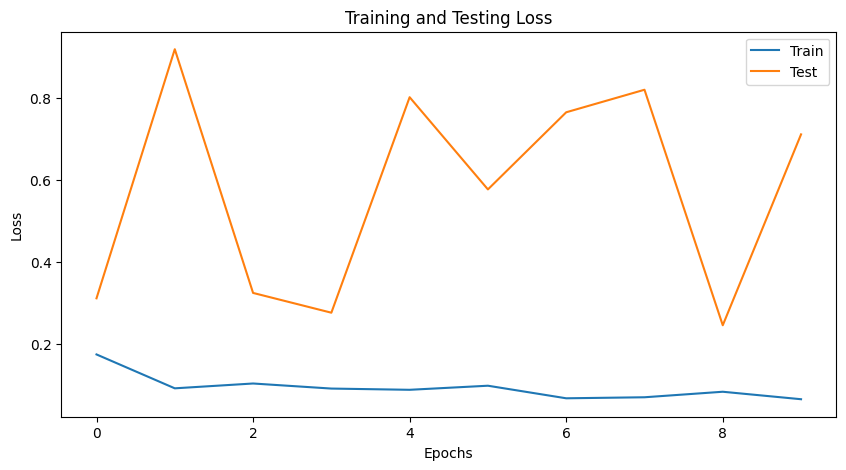

In [21]:
#lets plot the training and testing loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Training and Testing Loss")
plt.plot(train_losses,label="Train")
plt.plot(test_losses,label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

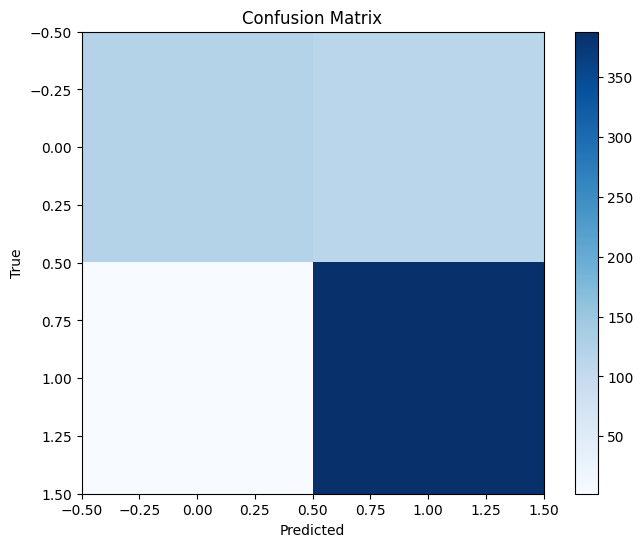

In [14]:
#plotting the confusion matrix
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

#evaluating the model
model.eval()

#inintializing the true and predicted labels lists
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu') 
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)     

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

#plotting the confusion matrix
conf_mat = np.zeros((2,2), dtype=int)
for t, p in zip(y_true, y_pred):
    conf_mat[t, p] += 1

plt.figure(figsize=(8,6))
plt.imshow(conf_mat, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()

In [15]:
#tommorow we willh increase the testing accuracy and also 
#make more visualizations like scatter plots etc
#adding the main grad cam too


Pneumonia recall: 95.38%
False Positives: 64
False Negatives: 18
True Positives: 372
True Negatives: 170
-------------------
F1 Score: 0.9007
-------------------
              precision    recall  f1-score   support

      NORMAL       0.90      0.73      0.81       234
   PNEUMONIA       0.85      0.95      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.84      0.85       624
weighted avg       0.87      0.87      0.87       624



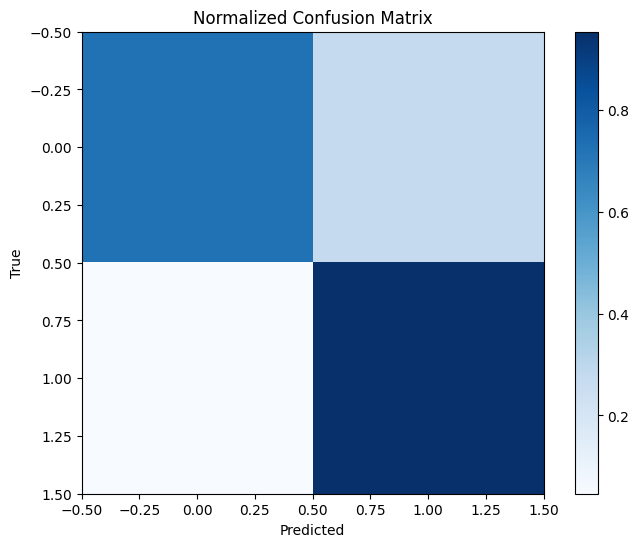

In [16]:
# Adjusting the decision threshold for pneumonia (class 1)
threshold = 0.93 # Increase this to be more conservative (default is 0.5)
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        # Predict pneumonia only if probability > threshold
        predicted = (probs[:, 1] > threshold).long()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
true_positive = np.sum((y_true == 1) & (y_pred == 1))
false_negative = np.sum((y_true == 1) & (y_pred == 0))
false_positive = np.sum((y_true == 0) & (y_pred == 1))
true_negative = np.sum((y_true == 0) & (y_pred == 0))
recall_pneumonia = true_positive / (true_positive + false_negative + 1e-6)
print(f"Pneumonia recall: {recall_pneumonia*100:.2f}%")
print(f"False Positives: {false_positive}")
print(f"False Negatives: {false_negative}")
print(f"True Positives: {true_positive}")
print(f"True Negatives: {true_negative}")
#calculating the f1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred)
print("-------------------")
print(f"F1 Score: {f1:.4f}")

#printing the classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
print("-------------------")
print(report)  

#printing the noramlised confusion mtrix
conf_mat = np.zeros((2,2), dtype=int)
for t, p in zip(y_true, y_pred):
    conf_mat[t, p] += 1
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]    
plt.figure(figsize=(8,6))
plt.imshow(conf_mat_normalized, cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()


In [17]:
# Install OpenCV for Python (correct package name is opencv-python)
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [18]:
#writing the grad cam function
import torch
import torch.nn.functional as F
import cv2
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, input_tensor, target_index):
        self.model.zero_grad()
        output = self.model(input_tensor)
        score = output[:, target_index]
        score.backward(retain_graph=True)
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()    
        cam = F.relu(cam)
        cam = cam.cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam

In [19]:
# Example: Overlay GradCAM heatmap with a medical colormap (e.g., 'jet') and proper normalization
def show_gradcam_on_image(img, cam, alpha=0.5, cmap='jet'):
    import matplotlib.pyplot as plt
    import cv2
    # img: numpy array, shape (H, W, 3), values in [0,1] or [0,255]
    # cam: numpy array, shape (H, W), values in [0,1]
    image, labels = test_data[0]
    
    cam = np.clip(cam, 0, 1)
    cam_uint8 = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    if img.max() > 1.0: img = img / 255.0
    overlay = heatmap / 255.0 * alpha + img * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('GradCAM Heatmap Overlay')
    plt.show()

C:\Users\2004s\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


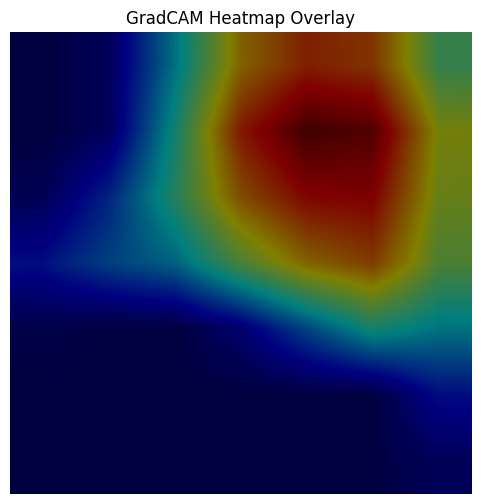

Patient status: 1 (PNEUMONIA)


In [23]:
# Find and visualize a pneumonia (sick) image with GradCAM
# Ensure grad_cam is initialized before this cell runs
# If not already done, run the cell that initializes grad_cam (see cell with GradCAM class and initialization)
# Find an index of a pneumonia image in the test set
pneumonia_idx = None
for i, (img_path, label) in enumerate(test_data.imgs):
    if label == train_data.class_to_idx['PNEUMONIA']:
        pneumonia_idx = i
        break
if pneumonia_idx is not None:
    img, label = test_data[pneumonia_idx]
    input_tensor = img.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
    # Ensure grad_cam is defined
    if 'grad_cam' not in globals():
        # For ResNet18WithDropout, the last conv layer is model.features[7][1].conv2
        target_layer = model.features[7][1].conv2
        grad_cam = GradCAM(model, target_layer)
    cam = grad_cam.generate_cam(input_tensor, target_index=label)
    # Convert tensor to numpy image for overlay
    img_np = img.permute(1,2,0).cpu().numpy()
    show_gradcam_on_image(img_np, cam, alpha=0.5, cmap='jet')
    print(f"Patient status: {label} ({list(train_data.class_to_idx.keys())[list(train_data.class_to_idx.values()).index(label)]})")
else:
    print("No pneumonia image found in test set.")

In [ ]:
# Show class mapping for reference
print("Class mapping:", train_data.class_to_idx)

Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
#initializing the grad cam with the model and target layer
# For ResNet18WithDropout, the last conv layer is model.features[7][1] (BasicBlock), use .conv2
target_layer = model.features[7][1].conv2
grad_cam = GradCAM(model, target_layer)

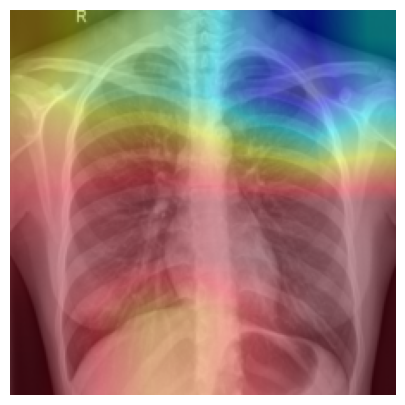

In [ ]:
#running the gradcam on one image
import matplotlib.pyplot as plt
model.eval()

#extracting one test image
image, label = test_data[10]
input_tensor = image.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

# Generate CAM for the predicted class
cam = grad_cam.generate_cam(input_tensor, target_index=label)   

# Visualize the CAM
image_np = image.permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

#overlaying the heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

if image_np.max() > 1.0: image_np = image_np / 255.0
overlay = heatmap / 255.0 * 0.4 + image_np * (1 - 0.4)
overlay = np.clip(overlay, 0, 1)

plt.figure(figsize=(10,5))
plt.imshow(overlay)
plt.axis('off')
plt.show()

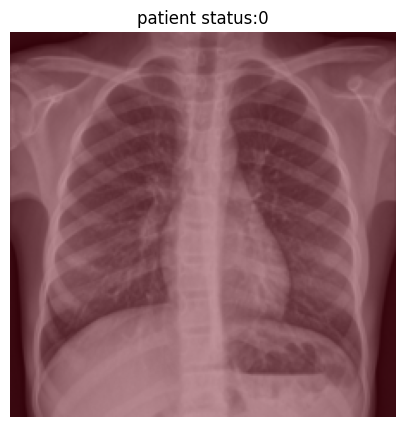

In [ ]:
#showing a postive example with grad cam
#this particular person does not have pneumonia
model.eval()
#extracting one test image

input_tensor = test_data[25][0].unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu') 

# Generate CAM for the predicted class
cam = grad_cam.generate_cam(input_tensor, target_index=1)   
# Visualize the CAM
image_np = test_data[25][0].permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
#overlaying the heatmap on the original image   
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  
if image_np.max() > 1.0: image_np = image_np / 255.0
overlay = heatmap / 255.0 * 0.4 + image_np * (1 - 0.4)
overlay = np.clip(overlay, 0, 1)    
plt.figure(figsize=(10,5))
plt.imshow(overlay)
plt.title(f"patient status:{label}")
plt.axis('off')

plt.show()

#also we want to mention in the image whether it is a true positive case of not


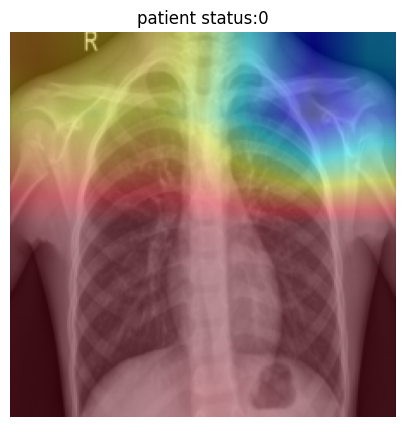

In [ ]:
#plotting a negative example with grad cam
#this particular person has pneumonia
model.eval()

#extracting one test image
input_tensor = test_data[0][0].unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

# Generate CAM for the predicted class
cam = grad_cam.generate_cam(input_tensor, target_index=0)   
# Visualize the CAM
image_np = test_data[0][0].permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
#overlaying the heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  
if image_np.max() > 1.0: image_np = image_np / 255.0
overlay = heatmap / 255.0 * 0.4 + image_np * (1 - 0.4)
overlay = np.clip(overlay, 0, 1)
plt.figure(figsize=(10,5))
plt.imshow(overlay)
plt.title(f"patient status:{label}")
plt.axis('off')
plt.show()


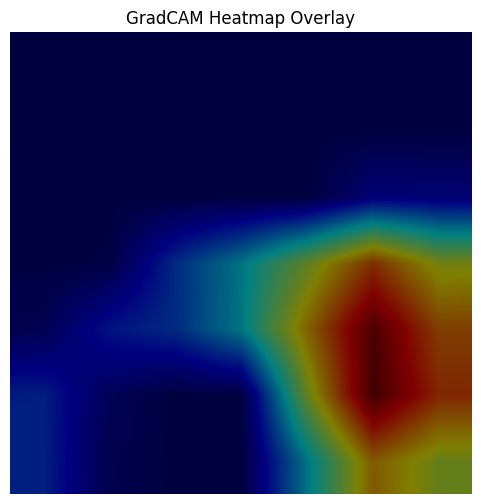

False Positive Example - True Label: 0 (NORMAL)


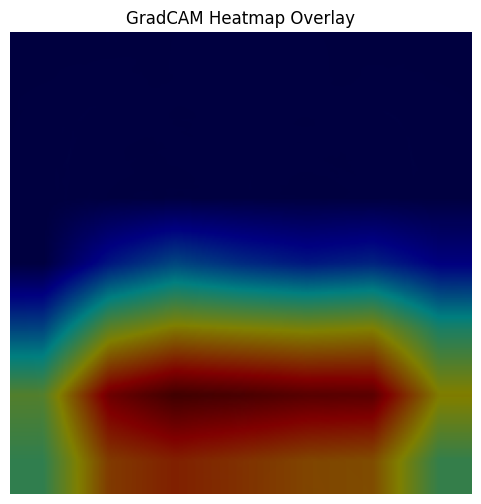

False Positive Example - True Label: 0 (NORMAL)


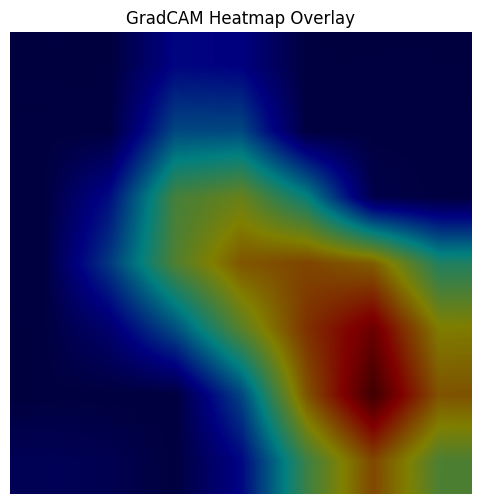

False Positive Example - True Label: 0 (NORMAL)


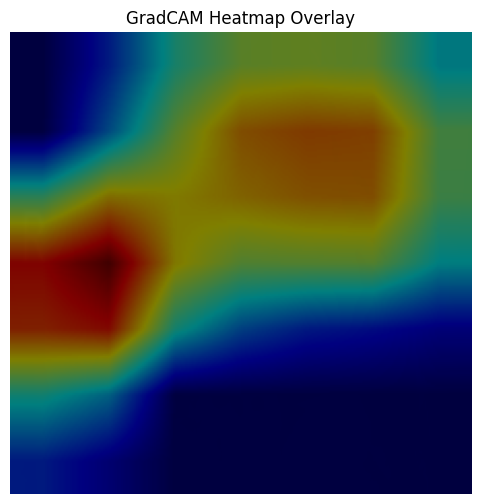

False Positive Example - True Label: 0 (NORMAL)


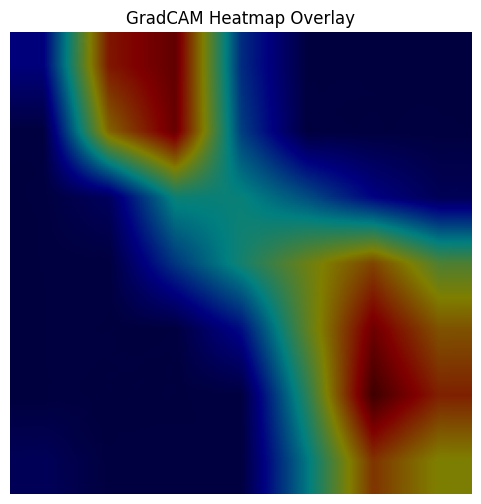

False Positive Example - True Label: 0 (NORMAL)


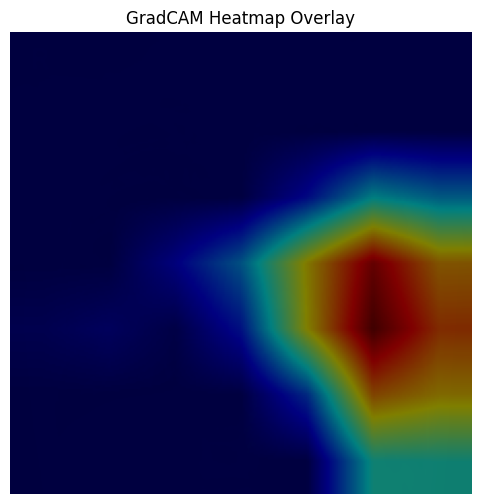

False Positive Example - True Label: 0 (NORMAL)


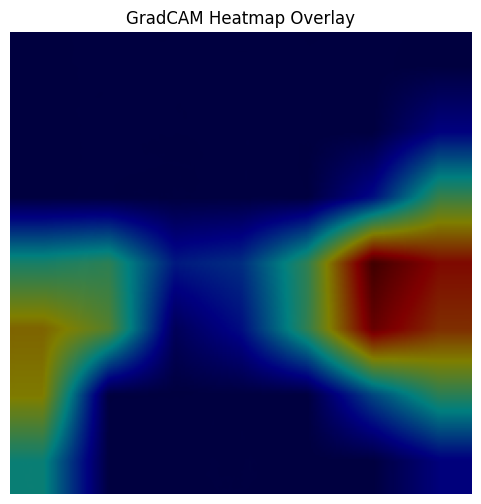

False Positive Example - True Label: 0 (NORMAL)


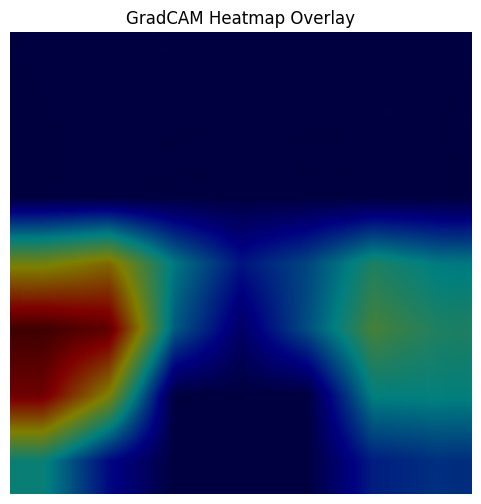

False Positive Example - True Label: 0 (NORMAL)


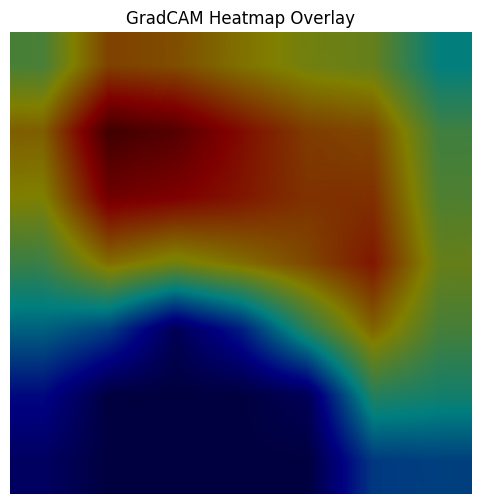

False Positive Example - True Label: 0 (NORMAL)


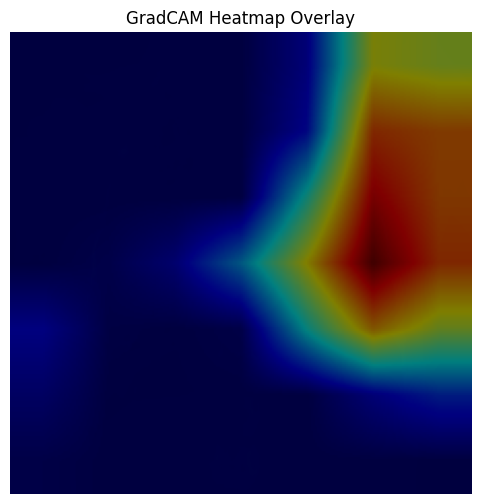

False Positive Example - True Label: 0 (NORMAL)


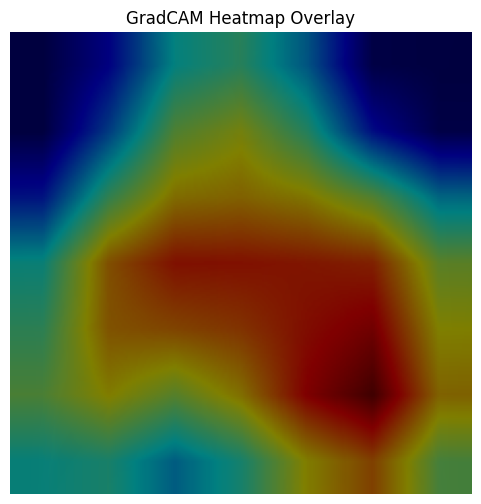

False Positive Example - True Label: 0 (NORMAL)


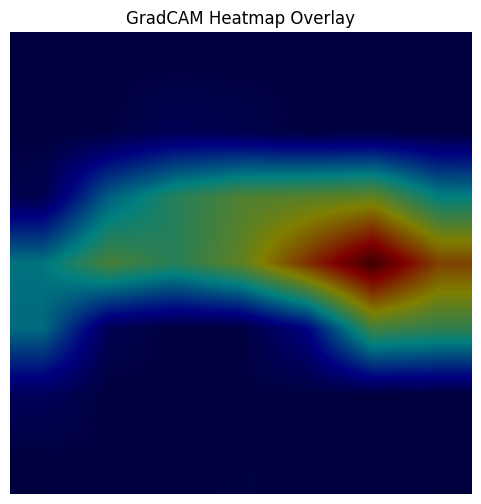

False Positive Example - True Label: 0 (NORMAL)


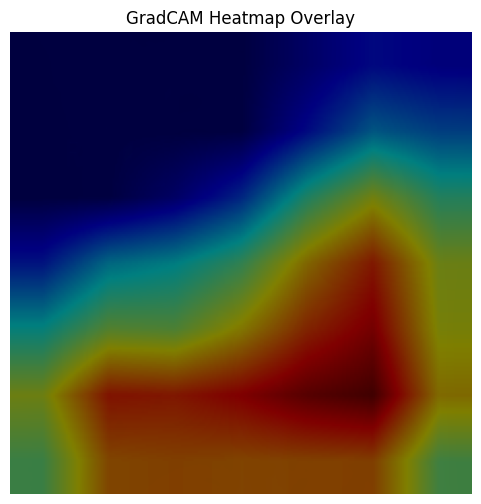

False Positive Example - True Label: 0 (NORMAL)


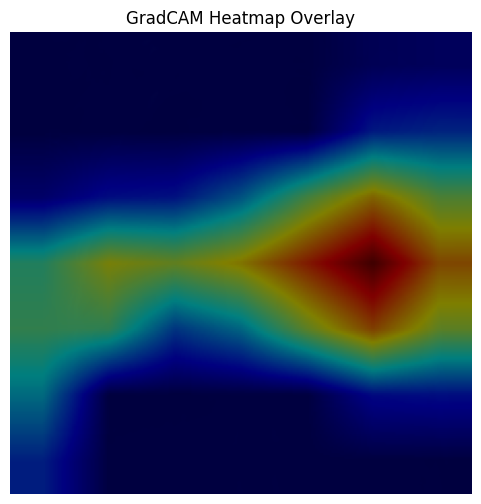

False Positive Example - True Label: 0 (NORMAL)


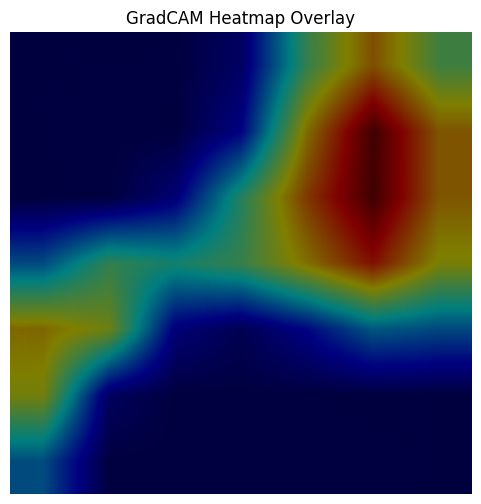

False Positive Example - True Label: 0 (NORMAL)


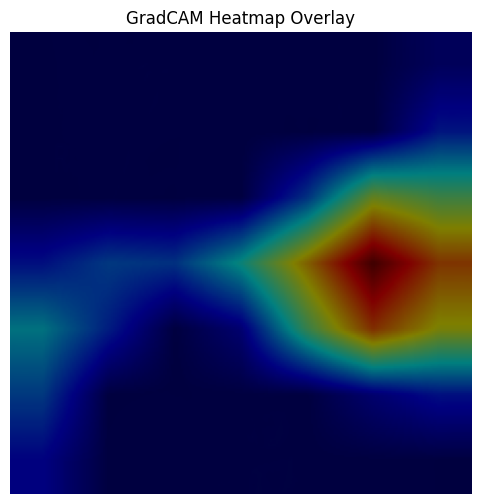

False Positive Example - True Label: 0 (NORMAL)


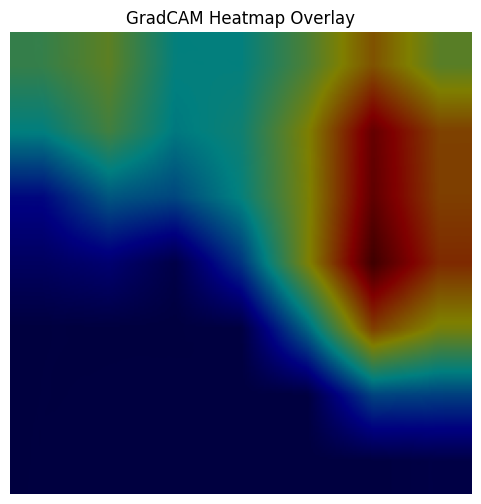

False Positive Example - True Label: 0 (NORMAL)


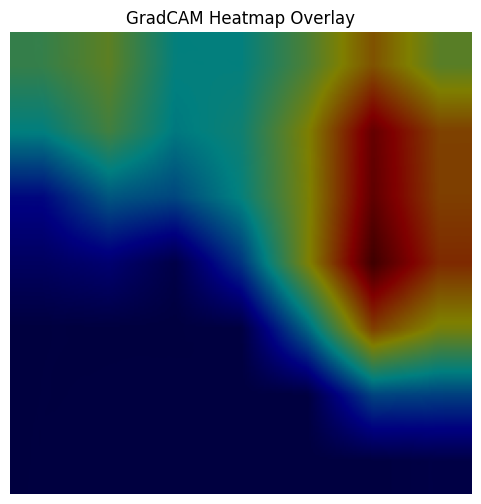

False Positive Example - True Label: 0 (NORMAL)


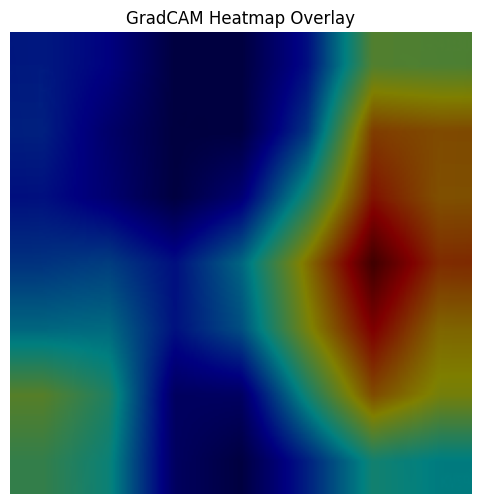

False Positive Example - True Label: 0 (NORMAL)


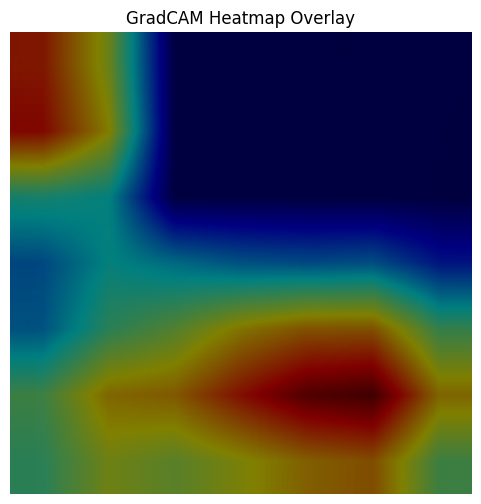

False Positive Example - True Label: 0 (NORMAL)


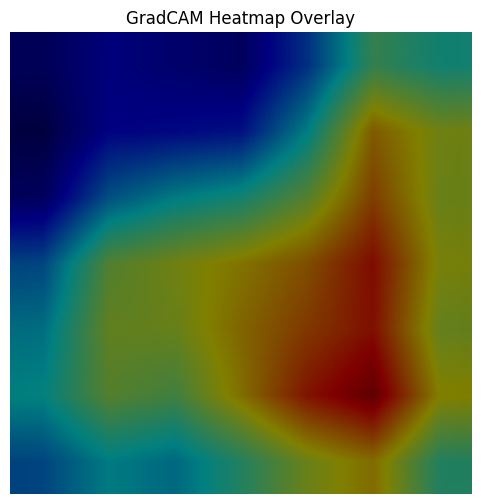

False Positive Example - True Label: 0 (NORMAL)


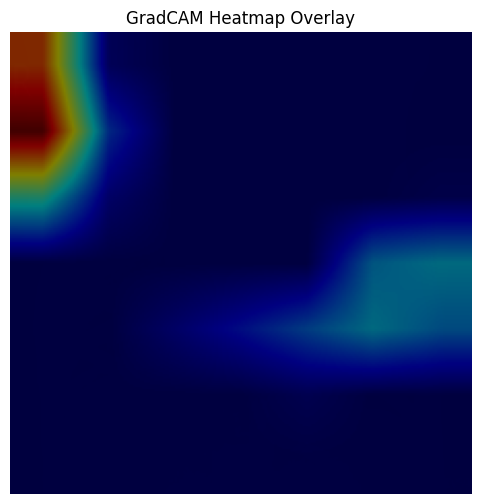

False Positive Example - True Label: 0 (NORMAL)


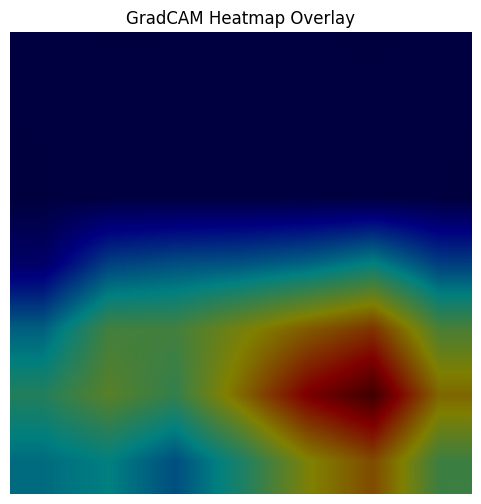

False Positive Example - True Label: 0 (NORMAL)


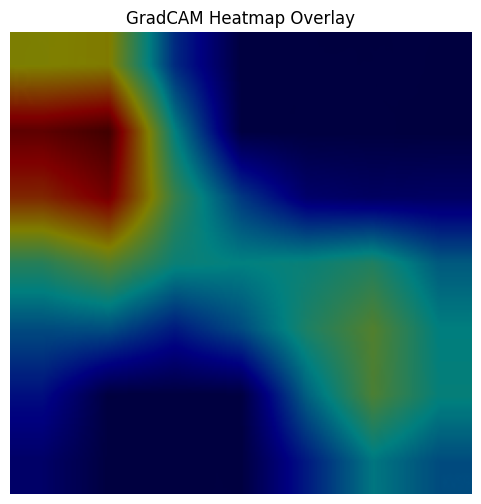

False Positive Example - True Label: 0 (NORMAL)


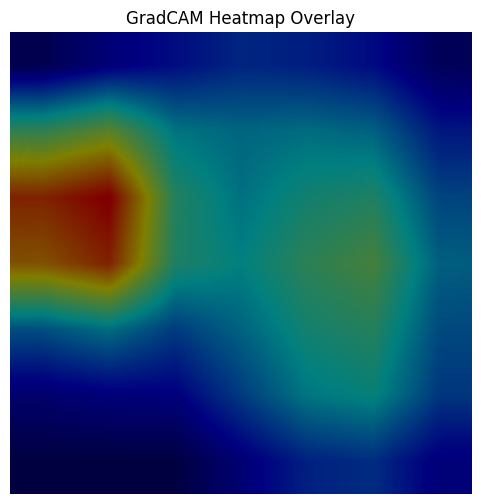

False Positive Example - True Label: 0 (NORMAL)


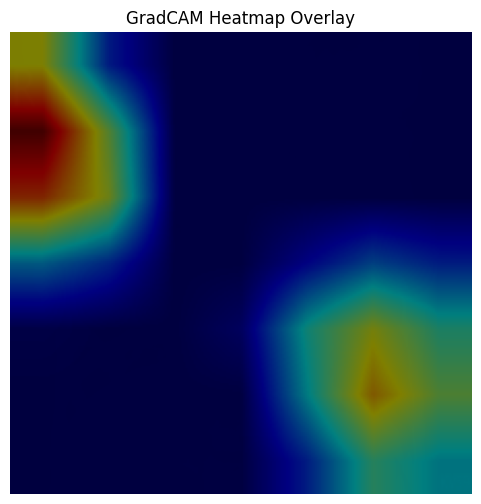

False Positive Example - True Label: 0 (NORMAL)


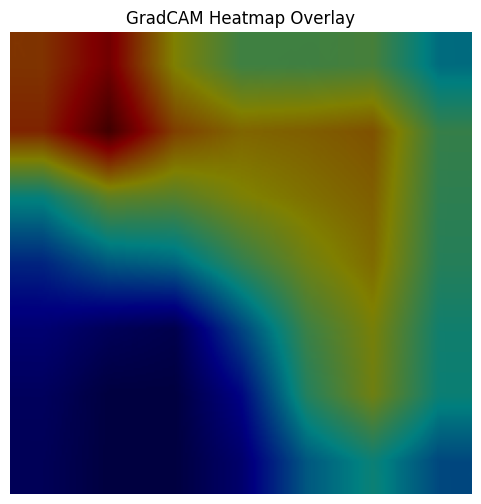

False Positive Example - True Label: 0 (NORMAL)


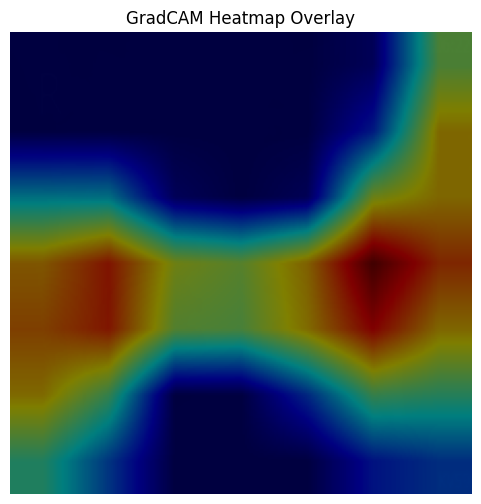

False Positive Example - True Label: 0 (NORMAL)


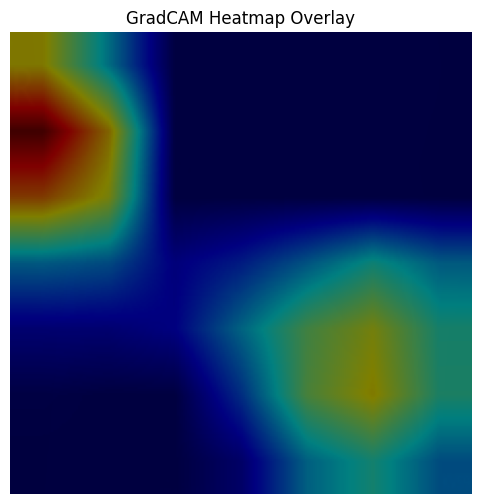

False Positive Example - True Label: 0 (NORMAL)


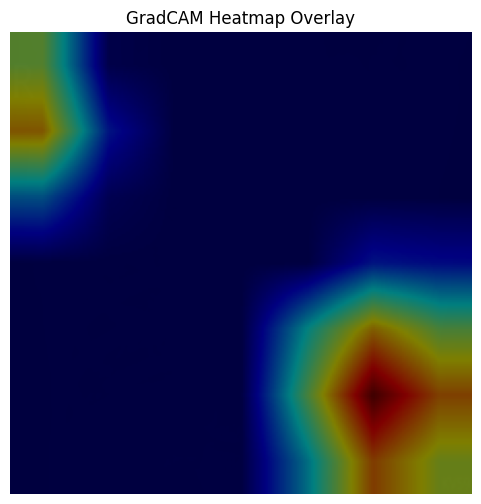

False Positive Example - True Label: 0 (NORMAL)


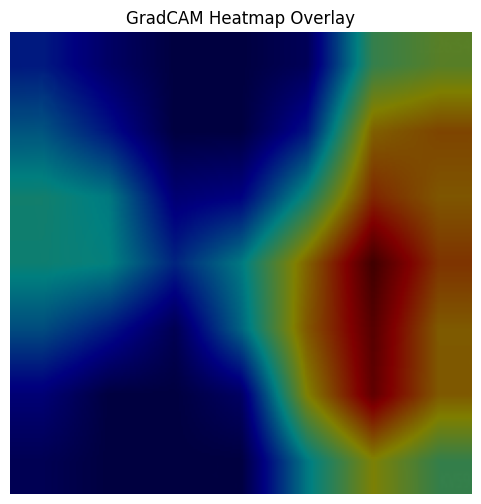

False Positive Example - True Label: 0 (NORMAL)


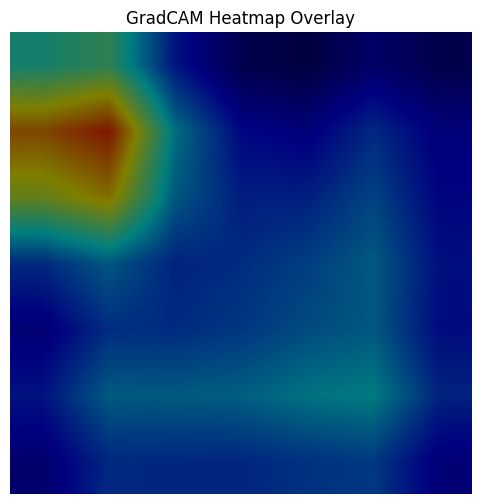

False Positive Example - True Label: 0 (NORMAL)


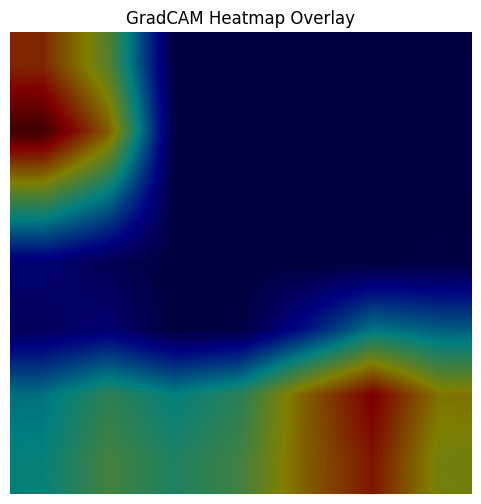

False Positive Example - True Label: 0 (NORMAL)


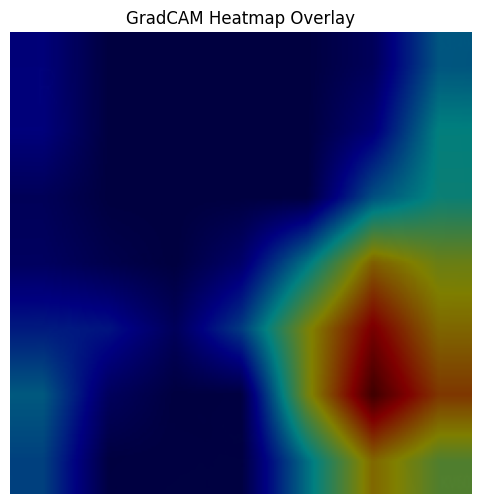

False Positive Example - True Label: 0 (NORMAL)


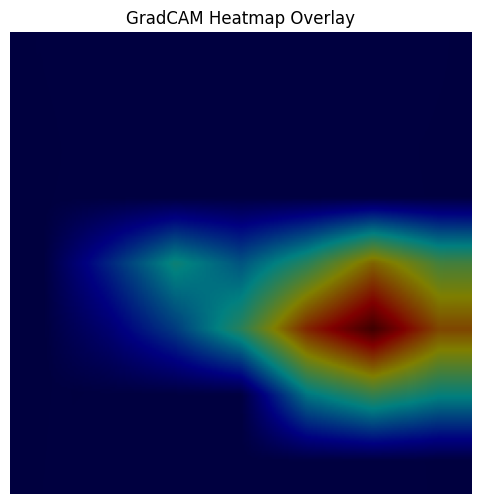

False Positive Example - True Label: 0 (NORMAL)


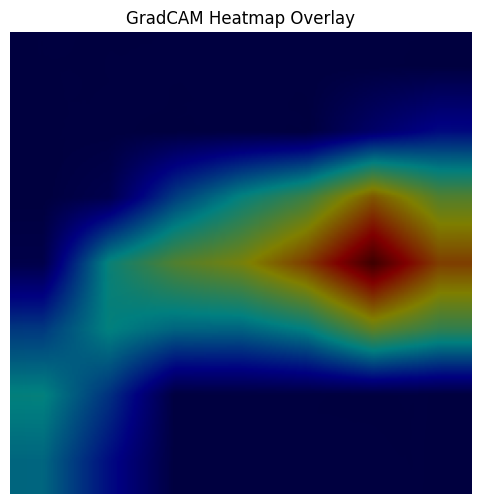

False Positive Example - True Label: 0 (NORMAL)


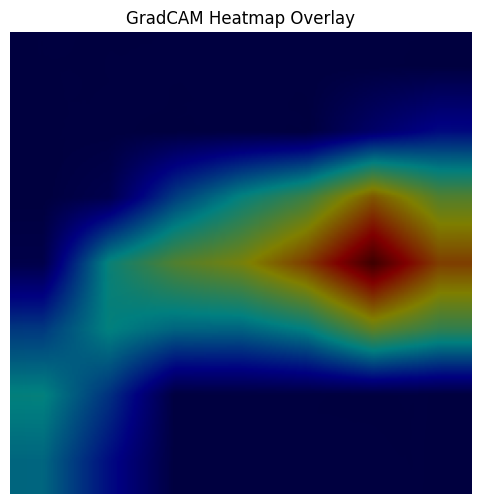

False Positive Example - True Label: 0 (NORMAL)


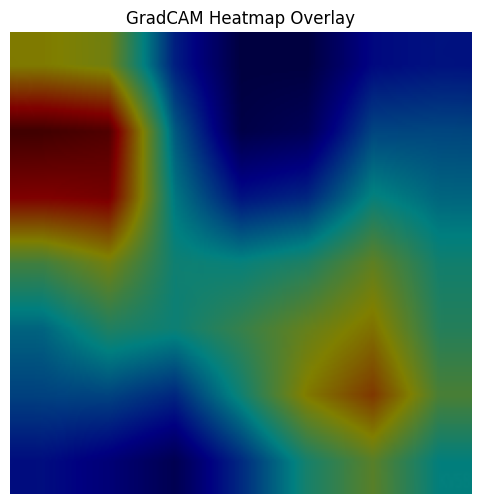

False Positive Example - True Label: 0 (NORMAL)


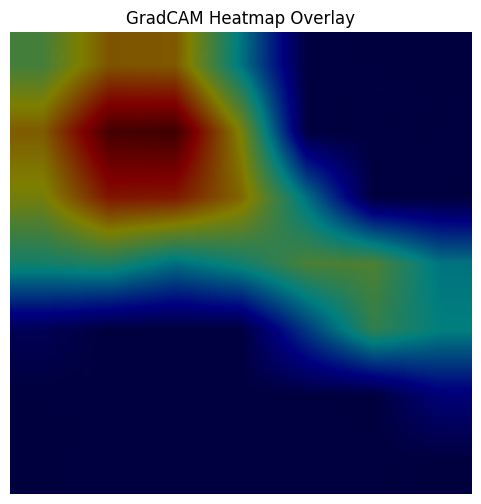

False Positive Example - True Label: 0 (NORMAL)


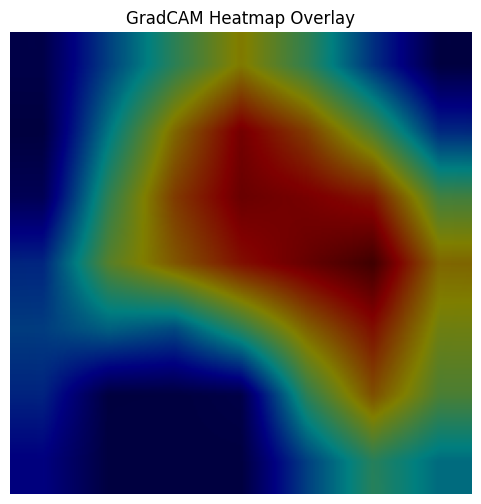

False Positive Example - True Label: 0 (NORMAL)


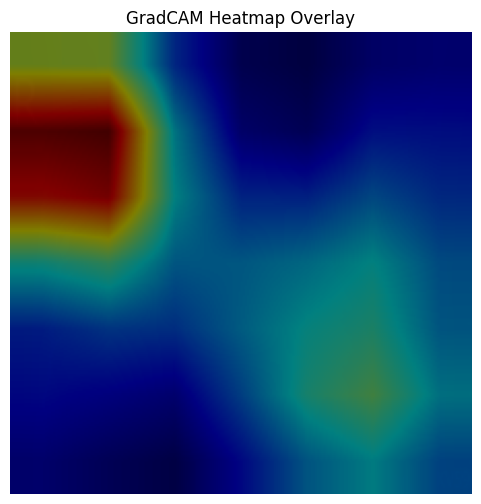

False Positive Example - True Label: 0 (NORMAL)


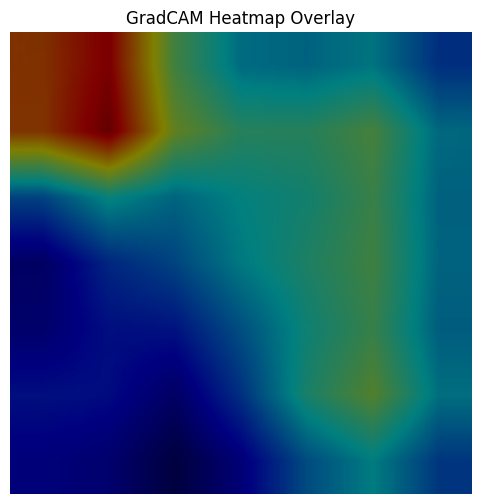

False Positive Example - True Label: 0 (NORMAL)


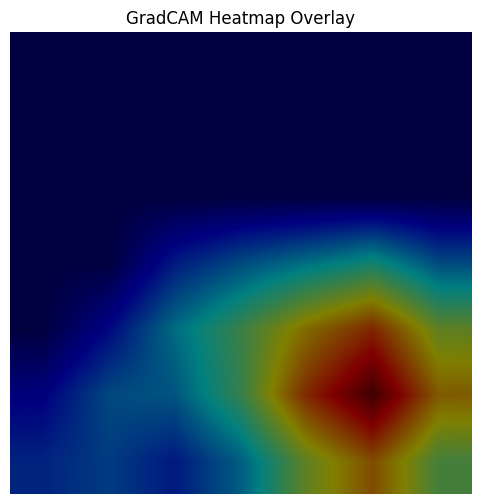

False Positive Example - True Label: 0 (NORMAL)


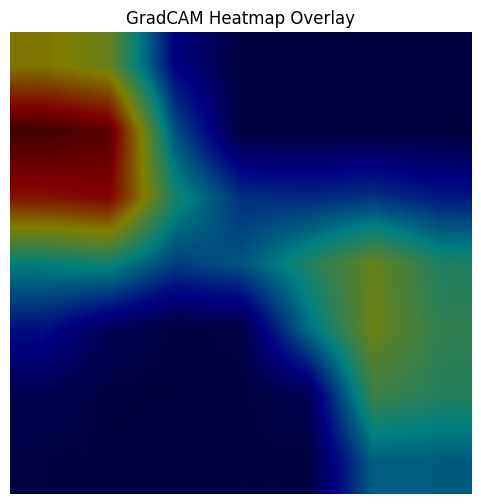

False Positive Example - True Label: 0 (NORMAL)


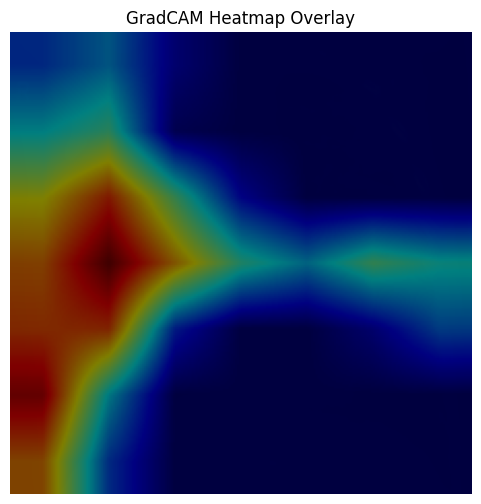

False Positive Example - True Label: 0 (NORMAL)


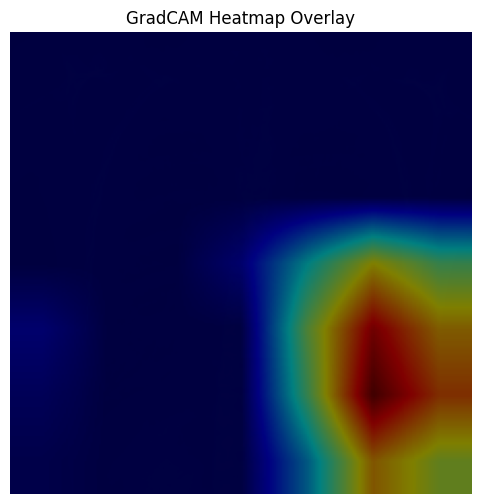

False Positive Example - True Label: 0 (NORMAL)


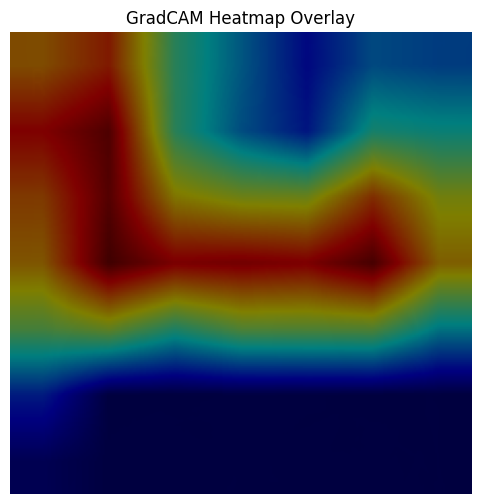

False Positive Example - True Label: 0 (NORMAL)


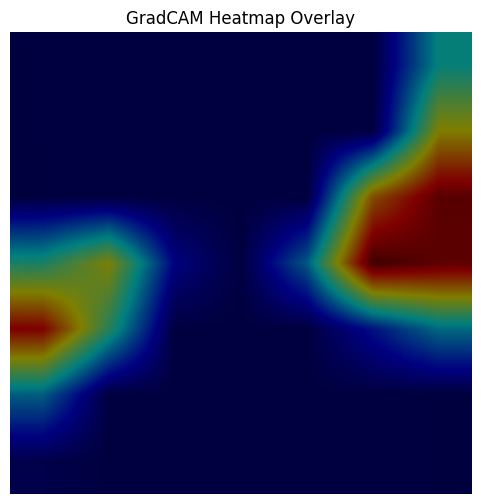

False Positive Example - True Label: 0 (NORMAL)


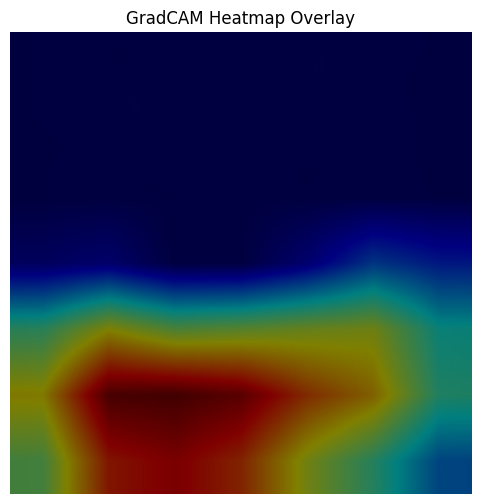

False Positive Example - True Label: 0 (NORMAL)


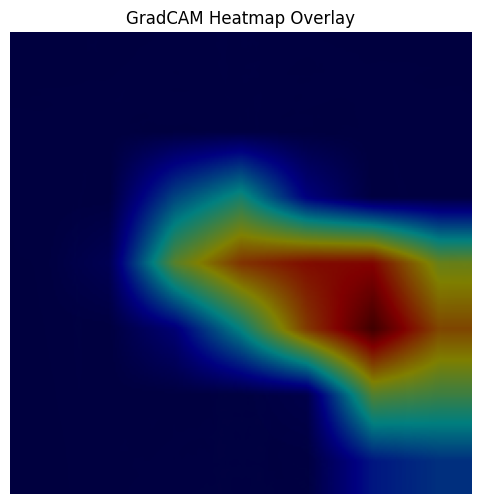

False Positive Example - True Label: 0 (NORMAL)


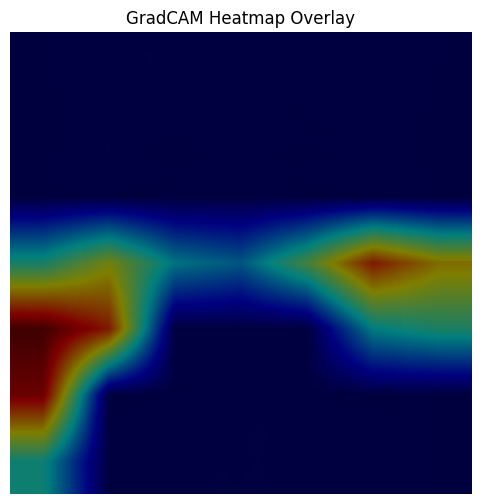

False Positive Example - True Label: 0 (NORMAL)


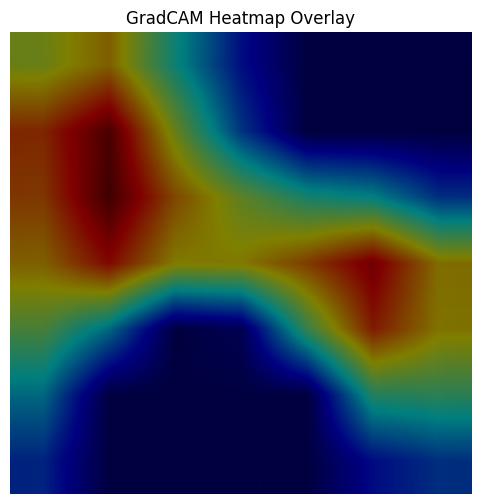

False Positive Example - True Label: 0 (NORMAL)


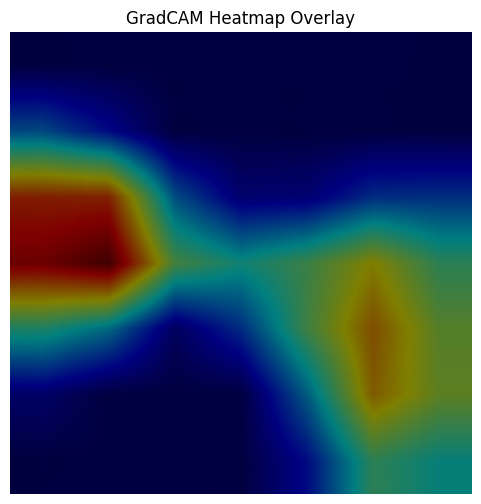

False Positive Example - True Label: 0 (NORMAL)


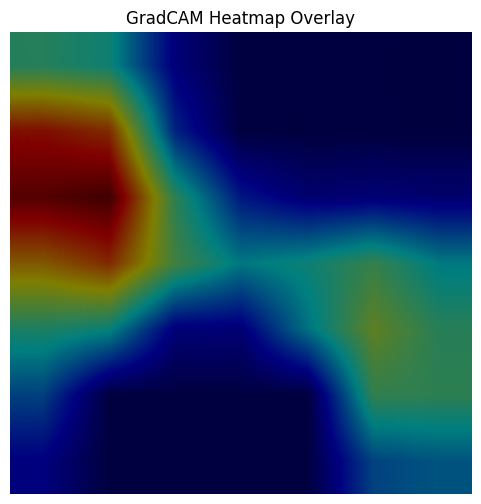

False Positive Example - True Label: 0 (NORMAL)


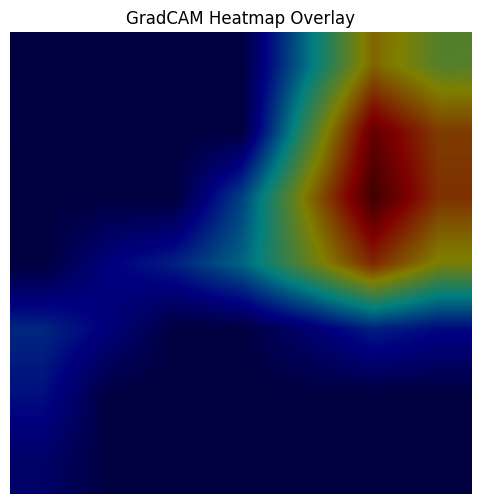

False Positive Example - True Label: 0 (NORMAL)


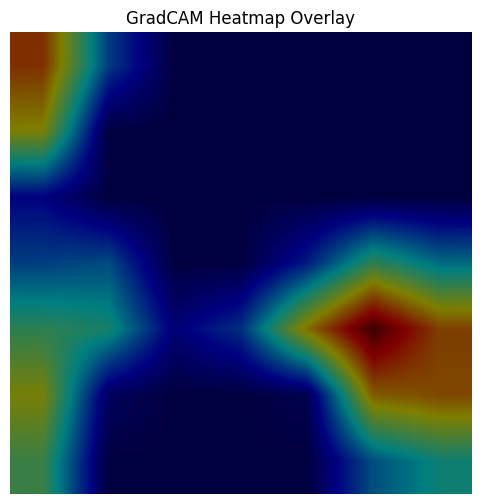

False Positive Example - True Label: 0 (NORMAL)


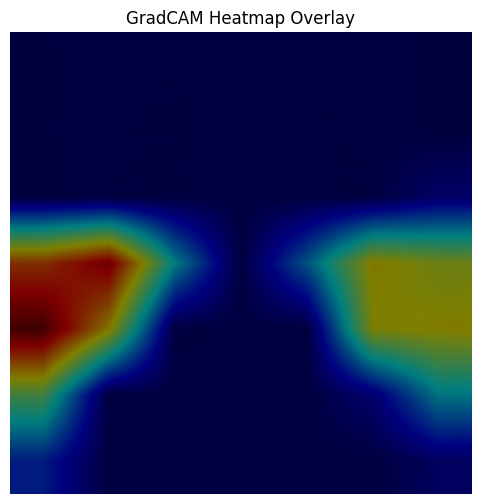

False Positive Example - True Label: 0 (NORMAL)


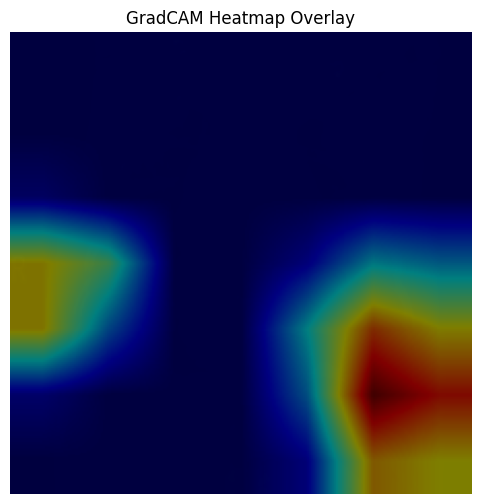

False Positive Example - True Label: 0 (NORMAL)


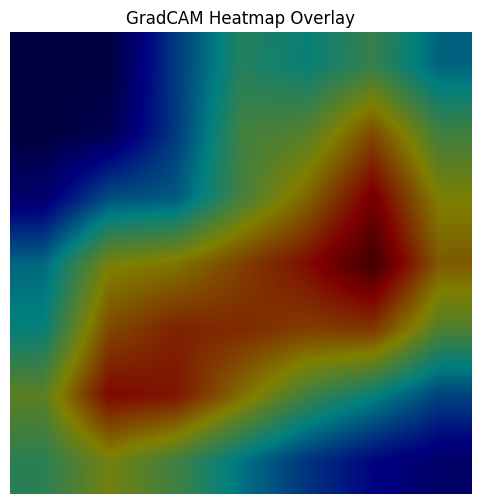

False Positive Example - True Label: 0 (NORMAL)


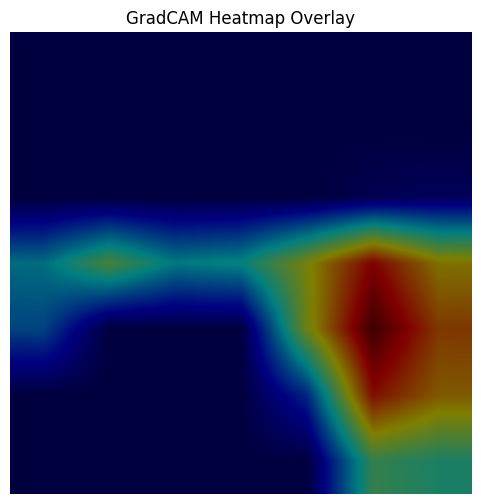

False Positive Example - True Label: 0 (NORMAL)


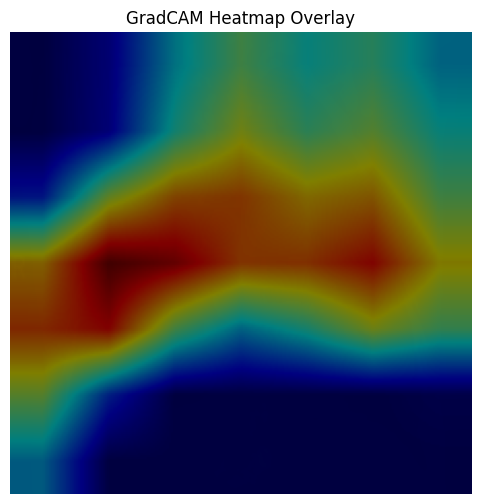

False Positive Example - True Label: 0 (NORMAL)


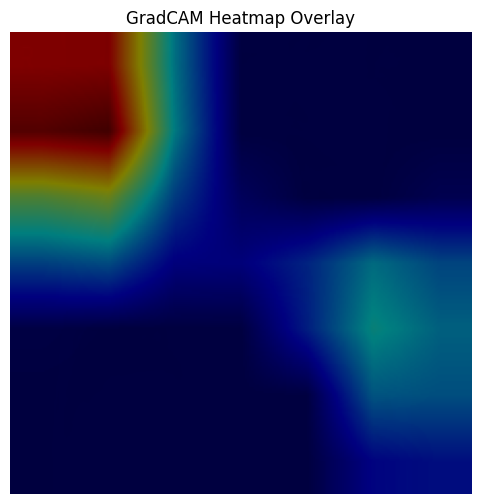

False Positive Example - True Label: 0 (NORMAL)


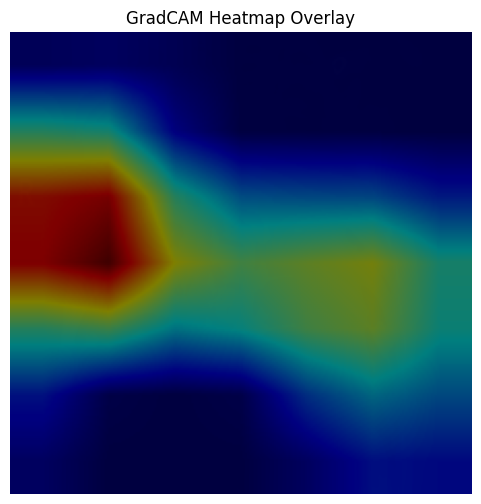

False Positive Example - True Label: 0 (NORMAL)


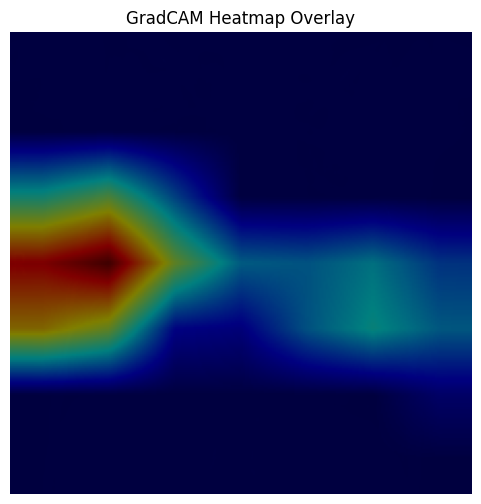

False Positive Example - True Label: 0 (NORMAL)


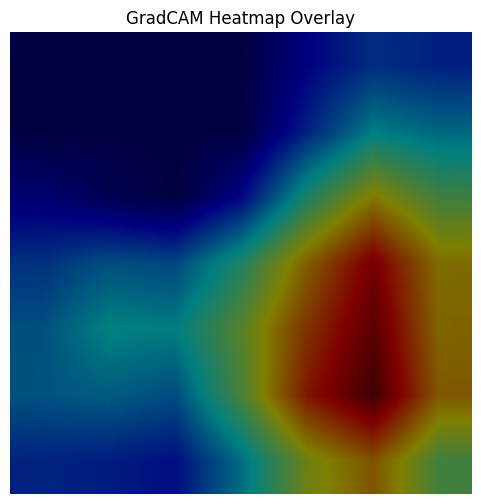

False Positive Example - True Label: 0 (NORMAL)


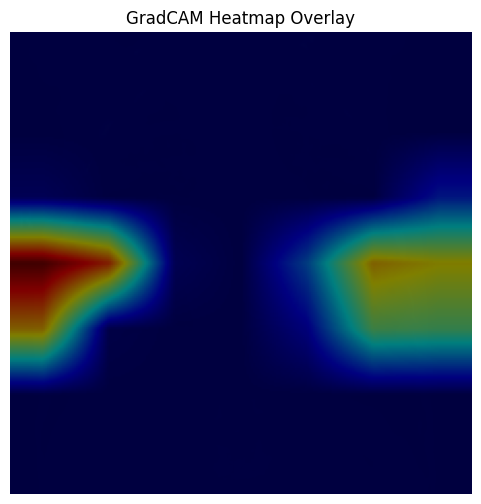

False Positive Example - True Label: 0 (NORMAL)


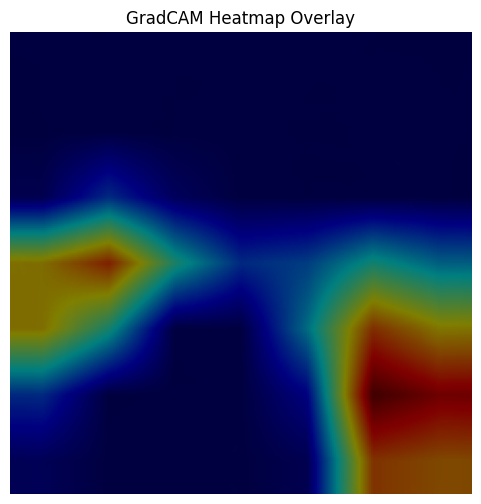

False Positive Example - True Label: 0 (NORMAL)


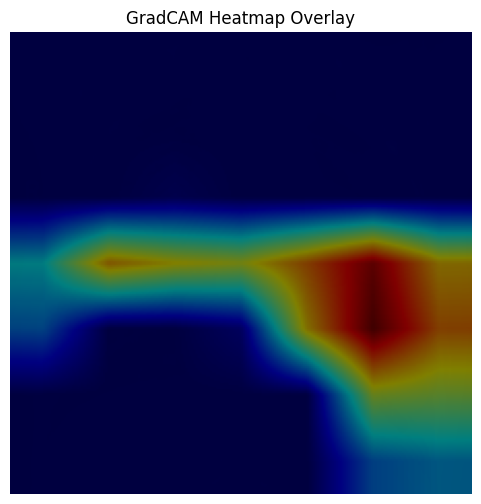

False Positive Example - True Label: 0 (NORMAL)


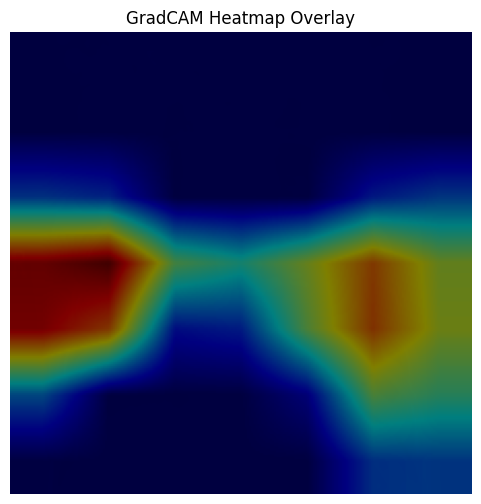

False Positive Example - True Label: 0 (NORMAL)


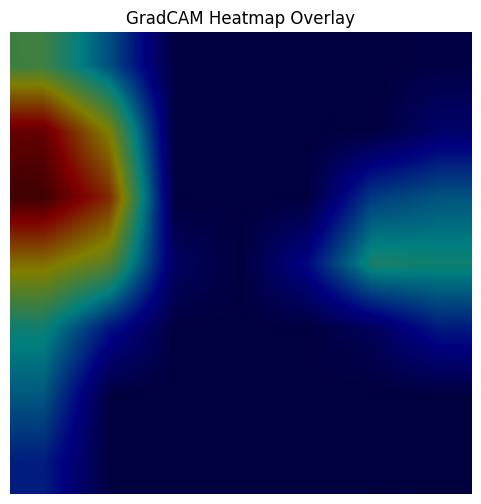

False Positive Example - True Label: 0 (NORMAL)


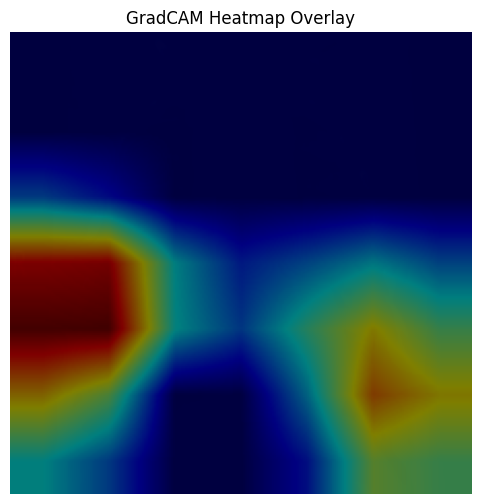

False Positive Example - True Label: 0 (NORMAL)


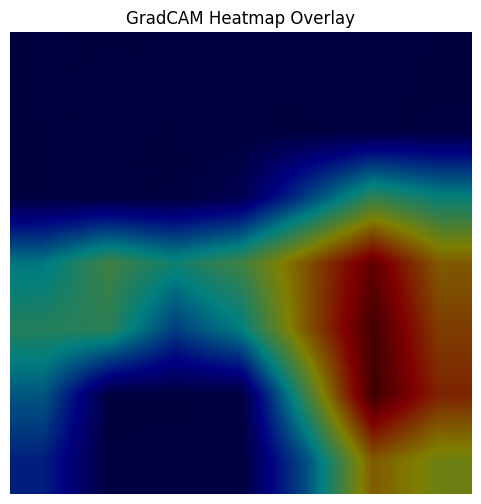

False Positive Example - True Label: 0 (NORMAL)


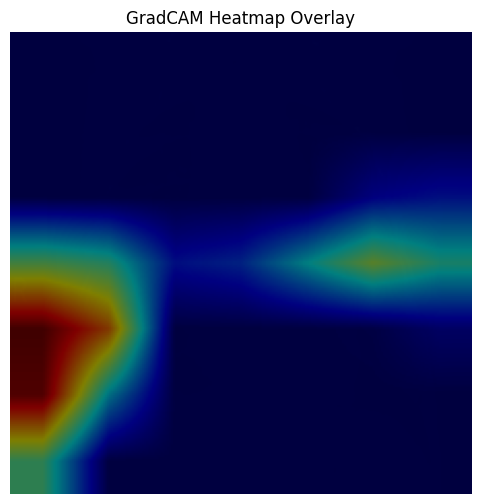

False Positive Example - True Label: 0 (NORMAL)


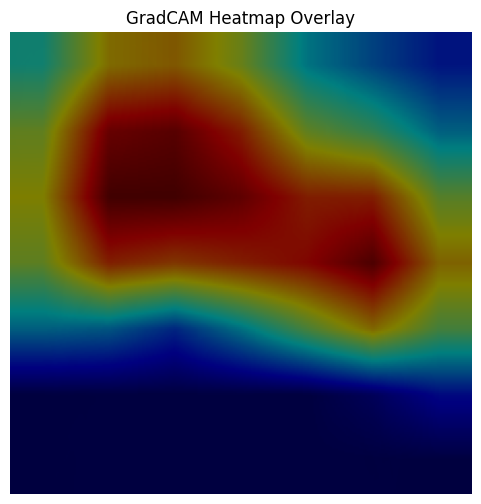

False Positive Example - True Label: 0 (NORMAL)


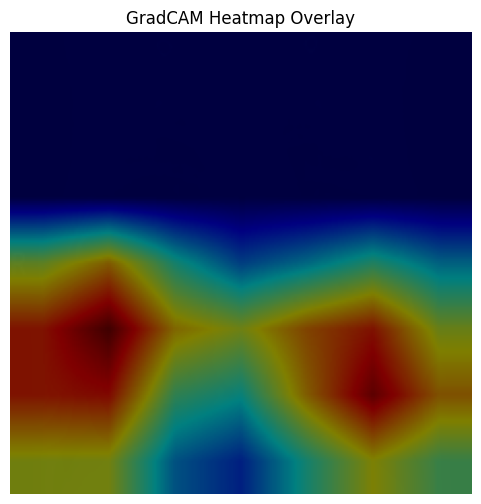

False Positive Example - True Label: 0 (NORMAL)


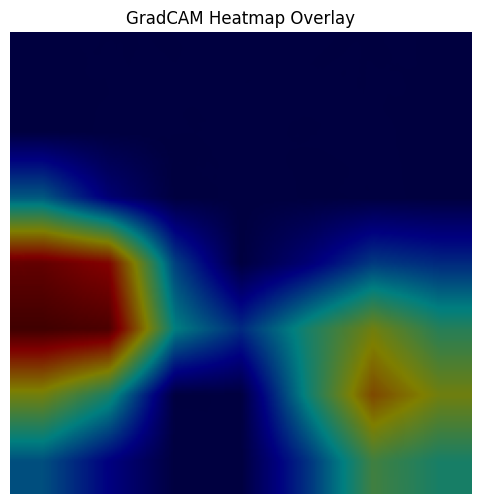

False Positive Example - True Label: 0 (NORMAL)
Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
#plotting the false positives and recall value
import matplotlib.pyplot as plt 
false_positive_indices = []
y_true = []
for i, (img, label) in enumerate(test_data):
    input_tensor = img.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)
    predicted = (probs[:, 1] > 0.9).long().item()  # Using threshold of 0.9
    y_true.append(label)
    if label == 0 and predicted == 1:
        false_positive_indices.append(i)
# Display false positive examples with GradCAM
for idx in false_positive_indices:
    img, label = test_data[idx]
    input_tensor = img.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
    cam = grad_cam.generate_cam(input_tensor, target_index=1)
    img_np = img.permute(1,2,0).cpu().numpy()
    show_gradcam_on_image(img_np, cam, alpha=0.5, cmap='jet')
    print(f"False Positive Example - True Label: {label} ({list(train_data.class_to_idx.keys())[list(train_data.class_to_idx.values()).index(label)]})")
# Show class mapping for reference
print("Class mapping:", train_data.class_to_idx)

# Install OpenCV for Python (correct package name is opencv-python)

In [ ]:
"""notes for today:
1. need to make the model less senstive to false positives
ideas for that:
- adjusting the threshold value for classification: still 79 false postive cases
- using s precision-recall curve to find the optimal threshold. 
okay will implement this right now - 0.93
"""

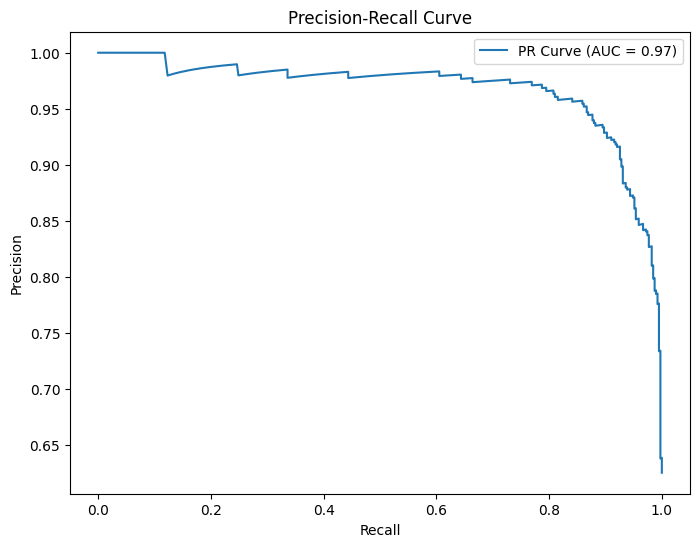

In [22]:
#plotting a precision-recall curve to find out the optimal threshold value
from sklearn.metrics import precision_recall_curve, auc
model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 'PNEUMONIA'
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})') 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [30]:
#testing on unseen data
import os
from PIL import Image

unseen_data = "test case.webp"

#processing the image for sending it to the model fro evaluation
unseen_data = Image.open(unseen_data).convert('RGB')
unseen_data = transformed_img(unseen_data)
unseen_data = unseen_data.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

#evaluating using the model
model.eval()

with torch.no_grad():
    output = model(unseen_data)
    probs = torch.softmax(output, dim=1)
    prob_in_percent = probs * 100
    predicted = (probs[:, 1] >0.93).long().item()  # Using threshold of 0.93
    class_mapping = {v: k for k, v in train_data.class_to_idx.items()}
    predicted_class = class_mapping[predicted]
    print(f"the predicted class is :{predicted_class}")
    print(f"proability of correctness of decision is: {prob_in_percent}")

    
    



the predicted class is :PNEUMONIA
proability of correctness of decision is: tensor([[1.2593e-03, 9.9999e+01]])


In [28]:
#testing another sample  on a normal x ray of a person

import os
from PIL import Image

#loading the imge
normal_patient = "normal.png"

#processing the image for sending it to the model fro evaluation
normal_patient = Image.open(normal_patient).convert('RGB')

#transforming the image
normal_patient = transformed_img(normal_patient)
normal_patient = normal_patient.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

#evaluating the model
model.eval()

with torch.no_grad():
    output = model(normal_patient)
    probs = torch.softmax(output, dim=1)
    threshold = 0.93
    predicted = (probs[:, 1]> threshold).long().item(
    )
    class_mapping = {v: k for k, v in train_data.class_to_idx.items()}
    predicted_class = class_mapping[predicted]
    print(f"The predicted class for the normal patient is: {predicted_class}")
    print("the accuracy is correct or not is denoted by this frequency:", probs.cpu().numpy())

    

The predicted class for the normal patient is: NORMAL
the accuracy is correct or not is denoted by this frequency: [[0.9210568  0.07894319]]


In [31]:
#computing the f2  score of the model
from sklearn.metrics import f1_score

#computing the f1 score
f1score = f1_score(y_true, y_pred)
print(f"the f1 score is: {f1score}")

the f1 score is: 0.9007263922518159


In [34]:
#saving the model
import torch

torch.save(model.state_dict(), "pneumonia_resnet18 model.pth")
print("model saved successfully.")

model saved successfully.


In [35]:
#loading the model
model.load_state_dict(torch.load("pneumonia_resnet18 model.pth"))
model.eval()

ResNet18WithDropout(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin